In [54]:
from datetime import datetime 
from itertools import chain
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
from tqdm import tqdm

DATA_PATH = Path("../data")

# Task 1
Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl).Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.


In [12]:
TRAIN_YEAR = 2019
TEST_YEAR = 2020

In [13]:
results = pd.read_pickle(DATA_PATH / "results.pkl")
players = pd.read_pickle(DATA_PATH / "players.pkl")
tournaments = pd.read_pickle(DATA_PATH / "tournaments.pkl")

In [14]:
tournaments_df = pd.DataFrame(tournaments).T
players_df = pd.DataFrame(players).T

In [15]:
def get_results(id_):
    t_results = results[id_]
    valid_t_results = [
        team
        for team in t_results
        if "mask" in team and team["mask"] and team["teamMembers"]
    ]
    if valid_t_results and (len(t_results) == len(valid_t_results)):
        return valid_t_results
    return None

tournaments_df["results"] = tournaments_df.id.apply(get_results)
tournaments_df = tournaments_df[~tournaments_df.results.isna()]
tournaments_df.sample(2)

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,results
2619,2619,Открытый чемпионат Архангельска,2013-11-24T00:00:00+04:00,2013-11-24T00:00:00+04:00,"{'id': 4, 'name': 'Региональный'}",/seasons/45,"[{'id': 17727, 'name': 'Антон', 'patronymic': ...",None,"{'1': 12, '2': 12, '3': 12, '4': 12, '5': 12}","[{'team': {'id': 239, 'name': 'Брейнозавры', '..."
5267,5267,Тыквенный пирог,2019-10-31T19:00:00+03:00,2019-11-06T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/53,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-11-06T23:59:00...,"{'1': 12, '2': 12, '3': 12}","[{'team': {'id': 74449, 'name': 'КС', 'town': ..."


In [16]:
def get_players_data(tournaments_df):
    data = [
        (tm["player"]["id"], r["team"]["id"], tournament["id"], r["mask"], len(r["mask"]), r["position"])
        for _, tournament in tournaments_df.iterrows()
        for r in tournament.results
        for tm in r["teamMembers"]
    ]
    players_data = pd.DataFrame(
        data, 
        columns=["player_id", "team_id", "tournament_id", "mask", "questions_total", "position"]
    )
    return players_data

def get_questions(players_df):
    questions_nums = []
    for l in players_df['questions_total']:
        questions_nums.extend(range(1, l + 1))
        
    questions_df = pd.DataFrame({
        'player_id': np.repeat(players_df['player_id'], players_df['questions_total']),
        'tournament_id': np.repeat(players_df['tournament_id'], players_df['questions_total']),
        'team_id': np.repeat(players_df['team_id'], players_df['questions_total']),
        'position': np.repeat(players_df['position'], players_df['questions_total']),
        'question_num': questions_nums,
        'is_correct': list(chain.from_iterable(players_df['mask']))
    })

    questions_df = questions_df[~questions_df['is_correct'].isin(['?', 'X'])]
    questions_df.loc[:, 'is_correct'] = questions_df['is_correct'].astype(np.int8)
    return questions_df

In [17]:
tournaments_train = tournaments_df[pd.to_datetime(tournaments_df.dateStart, utc=True).dt.year == TRAIN_YEAR].reset_index(drop=True)
tournaments_test = tournaments_df[pd.to_datetime(tournaments_df.dateStart, utc=True).dt.year == TEST_YEAR].reset_index(drop=True)

players_train = get_players_data(tournaments_train)
players_test = get_players_data(tournaments_test)

# filter players (remove players who participate in only one set)
players_mask = (players_df.id.isin(players_train.player_id.unique())) & (players_df.id.isin(players_test.player_id.unique()))
players_df = players_df.loc[players_mask]
players_train = players_train.loc[players_train.player_id.isin(players_df.id)]
players_test = players_test.loc[players_test.player_id.isin(players_df.id)]

questions_train = get_questions(players_train)
questions_test = get_questions(players_test)

In [18]:
questions_train

,player_id,tournament_id,team_id,position,question_num,is_correct
0,6212,4772,45556,1.0,1,1
0,6212,4772,45556,1.0,2,1
0,6212,4772,45556,1.0,3,1
0,6212,4772,45556,1.0,4,1
0,6212,4772,45556,1.0,5,1
...,...,...,...,...,...,...
377396,104477,6191,50396,14.0,32,0
377396,104477,6191,50396,14.0,33,0
377396,104477,6191,50396,14.0,34,1
377396,104477,6191,50396,14.0,35,0


In [19]:
questions_train.player_id.nunique(), questions_test.player_id.nunique()

(19376, 19376)

# Task 2
Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. 
Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [21]:
encoder = OneHotEncoder(handle_unknown="ignore")
player_ids = sorted(questions_train.player_id.unique())
train_data = encoder.fit_transform(questions_train[["player_id", "tournament_id", "question_num"]])
test_data = encoder.transform(questions_test[["player_id", "tournament_id", "question_num"]])

target_train = questions_train["is_correct"].values
target_test = questions_test["is_correct"].values

In [22]:
train_data.shape, test_data.shape

((12101414, 20526), (3640323, 20526))

In [23]:
baseline_model = LogisticRegression(solver="sag", n_jobs=-1)
baseline_model.fit(train_data, target_train)

LogisticRegression(n_jobs=-1, solver='sag')

In [24]:
def get_players_force(player_ids, lr_model):
    player_force = {}
    for p_id, coef in zip(player_ids, lr_model.coef_.flatten()):
        player_force[p_id] = coef
    return player_force

In [25]:
player_forces = get_players_force(player_ids, baseline_model)
players_df.loc[:, "player_force"] = players_df.loc[:, "id"].map(player_forces)
players_df = players_df.sort_values("player_force", ascending=False).reset_index(drop=True)
players_df

,id,name,patronymic,surname,player_force
0,27403,Максим,Михайлович,Руссо,2.585676
1,4270,Александра,Владимировна,Брутер,2.502998
2,28751,Иван,Николаевич,Семушин,2.466189
3,27822,Михаил,Владимирович,Савченков,2.399874
4,30152,Артём,Сергеевич,Сорожкин,2.347596
...,...,...,...,...,...
19371,218969,Анна,Андреевна,Кувшинова,-2.916357
19372,204714,Иван,Дмитриевич,Зарайский,-3.004242
19373,207194,Ксения,Руслановна,Мерзлякова,-3.037117
19374,213896,Мехрубон,Одилжоювич,Тошматов,-3.037141


# Task 3
Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. 
Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


In [82]:
def count_corr(questions_df, model):
    df = questions_df.copy()

    # get players foreces
    player_forces = get_players_force(player_ids, model)

    # predict ranks
    df["team_force"] = df.player_id.map(player_forces)
    df = df.groupby(["tournament_id", "team_id"]).sum().reset_index()
    df = df[["tournament_id", "team_id", "team_force"]]
    df['pred_rank'] = df.groupby("tournament_id")['team_force'].rank(ascending=False)

    # get true ranks
    df = df.merge(
        questions_df[["tournament_id", "team_id", "position"]].drop_duplicates(), on=["tournament_id", "team_id"]
    ).rename({"position": "true_rank"}, axis=1)

    # Count Correlations
    spearman_corrs = []
    kendall_corrs = []
    for tournament_id, g in df.groupby("tournament_id"):
        if len(g) == 1:  # tournament_id 6362
            continue
        spearman_corrs.append(spearmanr(g.true_rank.values, g.pred_rank.values).correlation)
        kendall_corrs.append(kendalltau(g.true_rank.values, g.pred_rank.values).correlation)

    spearman = np.mean(spearman_corrs)
    kendrall = np.mean(kendall_corrs)

    return spearman, kendrall

s, k = count_corr(questions_test, baseline_model)
print(f"Spearman: {s:.4f}")
print(f"Kendall: {k:.4f}")

Spearman: 0.7893
Kendall: 0.6303


# Task 4
Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


### E step
Получаем математическое ожидание скрытой переменной $z_{ij}$ - вероятность ответа игрока i на вопрос j.
Делаем предположение, что, если комаднда отвечает верно на вопрос, то хотя бы один из ее участников знает ответ, иначе - ответ не знает никто. 
  & \mbox{если команда не ответила на вопрос j}
  & \mbox{если команда ответила на вопрос j}
$$
E(z_{ij}) = \begin{cases}
  \frac{p(z_{ij}|\theta)}{1 - \prod{1 - p(z_{ij}|\theta)}}, & \textrm{если команда не ответила на вопрос j} \\
  0, & \textrm{иначе} \\
\end{cases}
$$
### M step
Обучаем регрессию с новыми метками

In [27]:
from sklearn.linear_model import LinearRegression
from copy  import deepcopy
from scipy.special import logit, expit

Step: 1/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7858
	  Kendall: 0.6261
Step: 2/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7822
	  Kendall: 0.6217
Step: 3/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7817
	  Kendall: 0.6210
Step: 4/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7819
	  Kendall: 0.6215
Step: 5/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7814
	  Kendall: 0.6214
Step: 6/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7817
	  Kendall: 0.6218
Step: 7/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7816
	  Kendall: 0.6214
Step: 8/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7810
	  Kendall: 0.6208
Step: 9/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7805
	  Kendall: 0.6204
Step: 10/10
	Count E-step...
	Count M-step...
	Score:
	  Spearman: 0.7799
	  Kendall: 0.6200


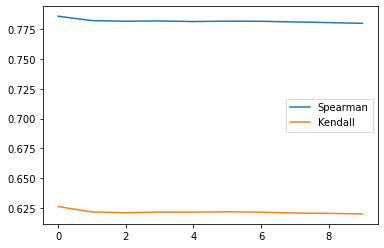

In [83]:
train_df = questions_train.copy()

train_df["player_proba"] = baseline_model.predict_proba(train_data)[:, 1]
best_score = 0
best_model = deepcopy(baseline_model)
n_steps = 10
em_model = LinearRegression()
spearman_history, kendall_history = [], []

for step in range(n_steps):
    print(f"Step: {step + 1}/{n_steps}")

    # E-step
    print("\tCount E-step...")
    train_df['player_negative_proba'] = 1 - train_df['player_proba']
    team_proba_df = 1 - train_df.groupby(
        ['tournament_id', 'team_id', 'question_num']
    ).player_negative_proba.prod().rename('team_proba', axis=1)

    train_df = train_df.merge(
        team_proba_df, 
        left_on=['tournament_id', 'team_id', 'question_num'],
        right_index=True,
    )

    train_df["z"] = train_df.player_proba / train_df.team_proba
    train_df["z"] = logit(np.clip(train_df.z * target_train, 1e-9, 1 - 1e-9))
    train_df = train_df.drop("team_proba", axis=1)

    # M-step
    print("\tCount M-step...") 
    em_model.fit(train_data, train_df.z)
    train_df['player_proba'] = expit(em_model.predict(train_data))

    # Count score
    print("\tScore:")
    spearman_corr, kendall_corr = count_corr(questions_test, em_model)
    print(f"\t  Spearman: {spearman_corr:.4f}")
    print(f"\t  Kendall: {kendall_corr:.4f}")
    if spearman_corr + kendall_corr > best_score:
        best_preds = expit(em_model.predict(test_data))
        best_model = deepcopy(em_model)

    spearman_history.append(spearman_corr)
    kendall_history.append(kendall_corr)

# plot history
plt.plot(spearman_history, label="Spearman")
plt.plot(kendall_history, label="Kendall")
plt.legend()
plt.show()